<a href="https://colab.research.google.com/github/neel26desai/basic_neural_networks/blob/main/neural_nw_using_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
#generating the dataset

# Defining the data
n, d = 500, 3  # 500 records, 3 features

# Creating x, values will be between -1 and 1 and the shape will be n, d
x = tf.random.uniform((n, d), minval=-1, maxval=1)

# Creating weights that allow us to get the y_true values
weights_true = tf.constant([[3], [3], [3]], dtype=tf.float32)
bias_true = tf.constant([1], dtype=tf.float32)

# Creating an equation  y_true
y_true = tf.einsum('ij,jk->ik', tf.pow(x, 3), weights_true) + \
         tf.einsum('ij,jk->ik', tf.pow(x, 2), weights_true) + \
         tf.einsum('ij,jk->ik', x, weights_true) + bias_true


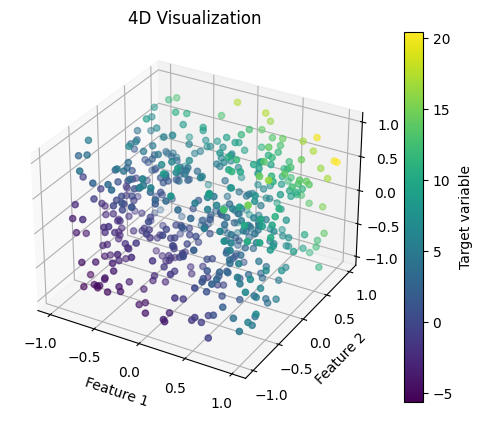

In [3]:
import matplotlib.pyplot as plt
#defining function for visualizaing the data
def visualize_4d_data(x, y_true):
    """
    Visualizes 4D data using a 3D scatter plot with color representing the fourth dimension.

    Args:
    x (numpy.ndarray): Input features with shape (n, 3).
    y_true (numpy.ndarray): Target variable with shape (n, 1).
    """
    x = x.numpy()
    y_true = y_true.numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_true.ravel(), cmap='viridis')
    plt.colorbar(scatter, label='Target variable')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    plt.title('4D Visualization')
    plt.show()

# Example usage
visualize_4d_data(x, y_true)

In [42]:
#performing a train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x.numpy(), y_true.numpy(), test_size=0.2, random_state=seed)

#Scratch

In [50]:
'''
Working Block
'''
import jax.numpy as jnp
from jax import random

def initialize_params(input_dim, hidden_dim, output_dim, key):
    keys = random.split(key, 3)
    w1 = random.normal(keys[0], (input_dim, hidden_dim))
    b1 = jnp.zeros(hidden_dim)
    w2 = random.normal(keys[1], (hidden_dim, hidden_dim))
    b2 = jnp.zeros(hidden_dim)
    w3 = random.normal(keys[2], (hidden_dim, output_dim))
    b3 = jnp.zeros(output_dim)
    return [(w1, b1), (w2, b2), (w3, b3)]

def relu(x):
    return jnp.maximum(0, x)

def forward(params, x):
    (w1, b1), (w2, b2), (w3, b3) = params
    x = relu(jnp.einsum('ij,jk->ik', x, w1) + b1)
    x = relu(jnp.einsum('ij,jk->ik', x, w2) + b2)
    x = jnp.einsum('ij,jk->ik', x, w3) + b3
    return x

def mse_loss(params, x, y):
    y_pred = forward(params, x)
    return jnp.mean(jnp.square(y_pred - y))

def update(params, x, y, learning_rate):
    (w1, b1), (w2, b2), (w3, b3) = params
    y_pred = forward(params, x)

    # Gradients for the output layer
    d_loss_y_pred = 2 * (y_pred - y) / y.shape[0]
    a2 = relu(jnp.einsum('ij,jk->ik', relu(jnp.einsum('ij,jk->ik', x, w1) + b1), w2) + b2)  # Activation from the second hidden layer
    d_loss_w3 = jnp.einsum('ij,ik->jk', a2, d_loss_y_pred)
    d_loss_b3 = jnp.sum(d_loss_y_pred, axis=0)

    # Gradients for the second hidden layer
    d_loss_a2 = jnp.einsum('ij,jk->ik', d_loss_y_pred, w3)
    d_a2_z2 = relu(d_loss_a2) > 0
    d_loss_z2 = d_loss_a2 * d_a2_z2
    a1 = relu(jnp.einsum('ij,jk->ik', x, w1) + b1)  # Activation from the first hidden layer
    d_loss_w2 = jnp.einsum('ij,ik->jk', a1, d_loss_z2)
    d_loss_b2 = jnp.sum(d_loss_z2, axis=0)

    # Gradients for the first hidden layer
    d_loss_a1 = jnp.einsum('ij,jk->ik', d_loss_z2, w2)
    d_a1_z1 = relu(d_loss_a1) > 0
    d_loss_z1 = d_loss_a1 * d_a1_z1
    d_loss_w1 = jnp.einsum('ij,ik->jk', x, d_loss_z1)
    d_loss_b1 = jnp.sum(d_loss_z1, axis=0)

    # Update the parameters
    new_w1 = w1 - learning_rate * d_loss_w1
    new_b1 = b1 - learning_rate * d_loss_b1
    new_w2 = w2 - learning_rate * d_loss_w2
    new_b2 = b2 - learning_rate * d_loss_b2
    new_w3 = w3 - learning_rate * d_loss_w3
    new_b3 = b3 - learning_rate * d_loss_b3

    return [(new_w1, new_b1), (new_w2, new_b2), (new_w3, new_b3)]


In [51]:
# Example usage
key = random.PRNGKey(0)
input_dim = 3
hidden_dim = 64
output_dim = 1
params = initialize_params(input_dim, hidden_dim, output_dim, key)
# Training loop
learning_rate = 0.01
epochs = 10
loss_history = []
for epoch in range(epochs):
    params = update(params, x_train, y_train, learning_rate)
    loss = mse_loss(params, x_train, y_train)
    loss_history.append(loss.item())
    print(f'Epoch {epoch + 1}, Loss: {loss}')


Epoch 1, Loss: 38.83658218383789
Epoch 2, Loss: 37.01376724243164
Epoch 3, Loss: 36.51265335083008
Epoch 4, Loss: 36.03139114379883
Epoch 5, Loss: 35.56917953491211
Epoch 6, Loss: 35.12527847290039
Epoch 7, Loss: 34.69895553588867
Epoch 8, Loss: 34.289512634277344
Epoch 9, Loss: 33.896278381347656
Epoch 10, Loss: 33.51862335205078


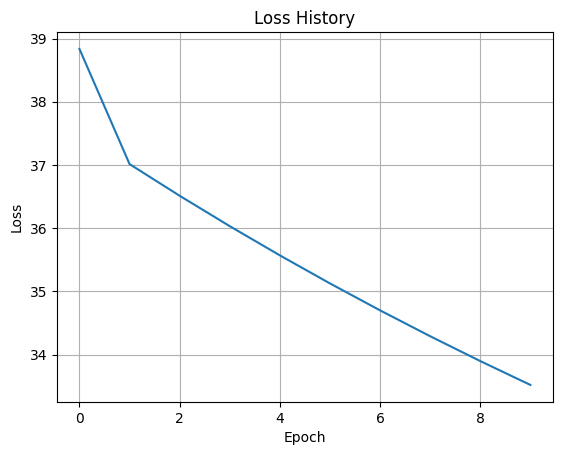

In [53]:
#plottig the loss history
plt.grid()
plt.plot(np.asarray(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

In [36]:
import numpy as np

def plot_function_and_predictions_4d(x, y_true, y_pred, output_dim=0, cmap='viridis'):
    """
    Plots the underlying function and the predicted function for a specific output dimension, with the fourth dimension represented by color.

    Args:
    x (numpy.ndarray): Input features with shape (n, 3).
    y_true (numpy.ndarray): True target values with shape (n, 2).
    y_pred (numpy.ndarray): Predicted target values with shape (n, 2).
    output_dim (int): The output dimension to visualize (0 or 1).
    cmap (str): Color map to use for the fourth dimension.
    """
    # y_pred = y_pred.detach().numpy()
    # y_true = y_true.detach().numpy()
    # x = x.detach().numpy()
    fig = plt.figure(figsize=(12, 6))

    # Define the color map for the fourth dimension
    norm = plt.Normalize(vmin=min(x[:, 2]), vmax=max(x[:, 2]))
    colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))

    # Plot the true values
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], y_true[:, output_dim], c=colors, marker='o', label='True')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel(f'Y{output_dim + 1}')
    ax1.set_title('Underlying Function')

    # Plot the predicted values
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], y_pred[:, output_dim], c=colors, marker='^', label='Predicted')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    ax2.set_zlabel(f'Y{output_dim + 1}')
    ax2.set_title('Predicted Function')

    # Add a color bar to indicate the fourth dimension
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(x[:, 2])
    plt.colorbar(mappable, ax=[ax1, ax2], label='X3 (Fourth Dimension)')

    plt.legend()
    plt.show()

43.845966


<ipython-input-36-5873a28e1295>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))


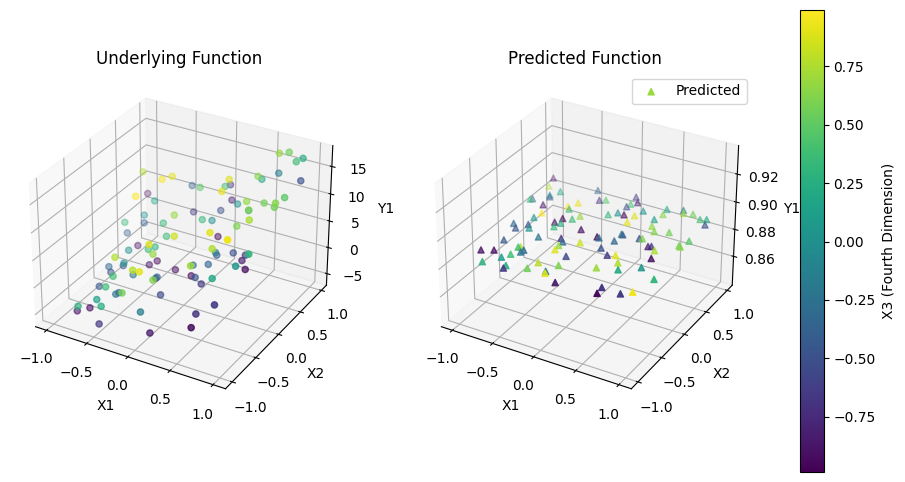

In [54]:
y_pred = forward(params, x_test)
print(mse_loss(params, x_test, y_test))
plot_function_and_predictions_4d(x_test, y_test, y_pred)

# Low level API

In [55]:
import jax
import jax.numpy as jnp
from jax import random, grad

def initialize_params(input_dim, hidden_dim, output_dim, key):
    keys = random.split(key, 3)
    w1 = random.normal(keys[0], (input_dim, hidden_dim))
    b1 = jnp.zeros(hidden_dim)
    w2 = random.normal(keys[1], (hidden_dim, hidden_dim))
    b2 = jnp.zeros(hidden_dim)
    w3 = random.normal(keys[2], (hidden_dim, output_dim))
    b3 = jnp.zeros(output_dim)
    return [(w1, b1), (w2, b2), (w3, b3)]

def relu(x):
    return jnp.maximum(0, x)

def forward(params, x):
    (w1, b1), (w2, b2), (w3, b3) = params
    x = relu(jnp.dot(x, w1) + b1)
    x = relu(jnp.dot(x, w2) + b2)
    x = jnp.dot(x, w3) + b3
    return x

def mse_loss(params, x, y):
    y_pred = forward(params, x)
    return jnp.mean(jnp.square(y_pred - y))

def update(params, x, y, learning_rate):
    grads = grad(mse_loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db) for (w, b), (dw, db) in zip(params, grads)]

# Example usage
key = random.PRNGKey(0)
input_dim = 3
hidden_dim = 64
output_dim = 1
params = initialize_params(input_dim, hidden_dim, output_dim, key)

# Training loop
learning_rate = 0.001
epochs = 10
loss_history = []
for epoch in range(epochs):
    params = update(params, x_train, y_train, learning_rate)
    loss = mse_loss(params, x_train, y_train)
    loss_history.append(loss.item())
    print(f'Epoch {epoch + 1}, Loss: {loss}')


Epoch 1, Loss: 1103.6837158203125
Epoch 2, Loss: 3486.24169921875
Epoch 3, Loss: 4616.0458984375
Epoch 4, Loss: 631.2054443359375
Epoch 5, Loss: 112.01068878173828
Epoch 6, Loss: 40.13140106201172
Epoch 7, Loss: 23.450712203979492
Epoch 8, Loss: 17.870834350585938
Epoch 9, Loss: 15.131322860717773
Epoch 10, Loss: 13.423945426940918


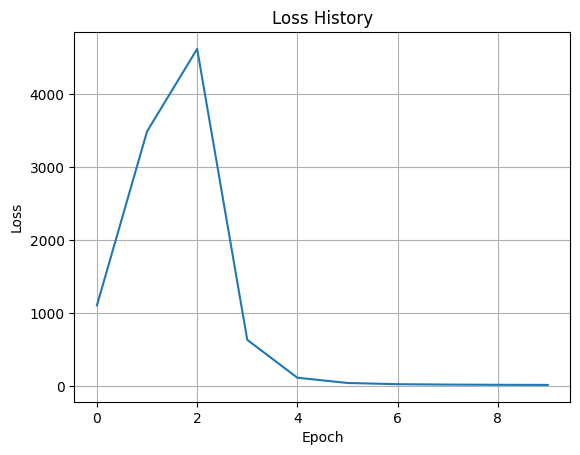

In [56]:
#plottig the loss history
plt.grid()
plt.plot(np.asarray(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

21.605127


<ipython-input-36-5873a28e1295>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))


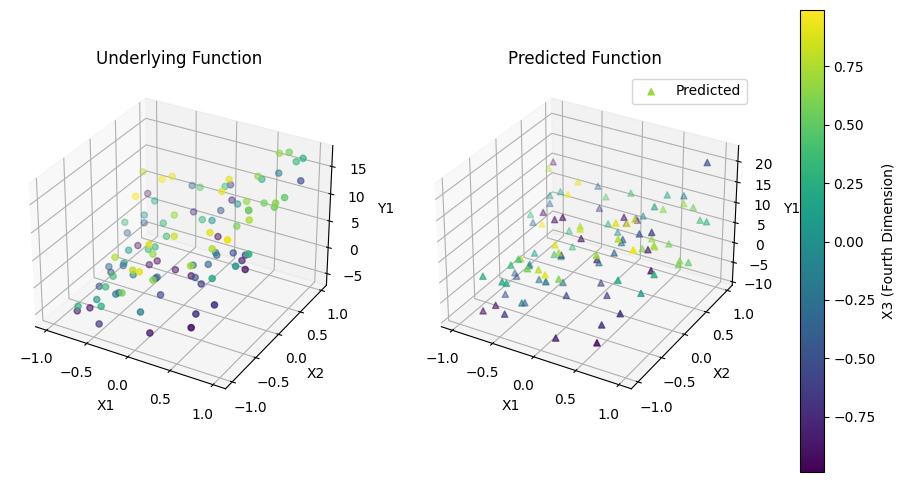

In [57]:
y_pred = forward(params, x_test)
print(mse_loss(params, x_test, y_test))
plot_function_and_predictions_4d(x_test, y_test, y_pred)

# High Level API

In [68]:
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from flax.training import train_state
import optax

class MyModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

def create_train_state(rng_key, learning_rate, input_shape):
    model = MyModel()
    params = model.init(rng_key, jnp.ones(input_shape))['params']
    tx = optax.sgd(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = MyModel().apply({'params': params}, batch['x'])
        return jnp.mean((logits - batch['y']) ** 2)
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

def predict(state, x_test):
    return MyModel().apply({'params': state.params}, x_test)


# Example usage
key = random.PRNGKey(0)
input_shape = (3,)
learning_rate = 0.01

state = create_train_state(key, learning_rate, input_shape)

# Training loop
epochs = 10
batch = {'x': x_train, 'y': y_train}
loss_history = []
for epoch in range(epochs):
    state, loss = train_step(state, batch)
    loss_history.append(loss)
    print(f'Epoch {epoch + 1}, Loss: {loss}')


Epoch 1, Loss: 42.334190368652344
Epoch 2, Loss: 36.20143508911133
Epoch 3, Loss: 31.40067481994629
Epoch 4, Loss: 26.82615089416504
Epoch 5, Loss: 22.277034759521484
Epoch 6, Loss: 17.982669830322266
Epoch 7, Loss: 14.280844688415527
Epoch 8, Loss: 11.391074180603027
Epoch 9, Loss: 9.307473182678223
Epoch 10, Loss: 7.816965103149414


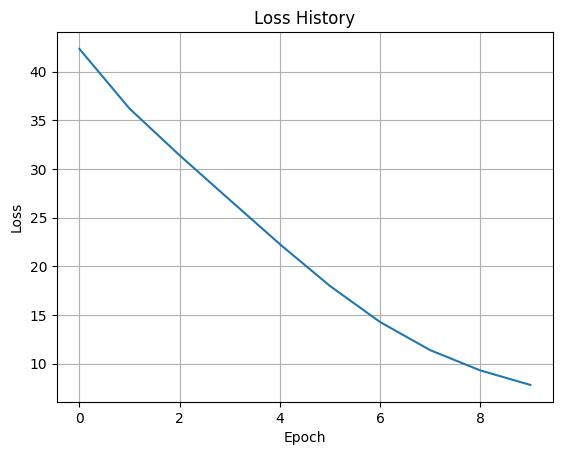

In [67]:
#plottig the loss history
plt.grid()
plt.plot(np.asarray(loss_history))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

8.638


<ipython-input-36-5873a28e1295>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(x[:, 2]))


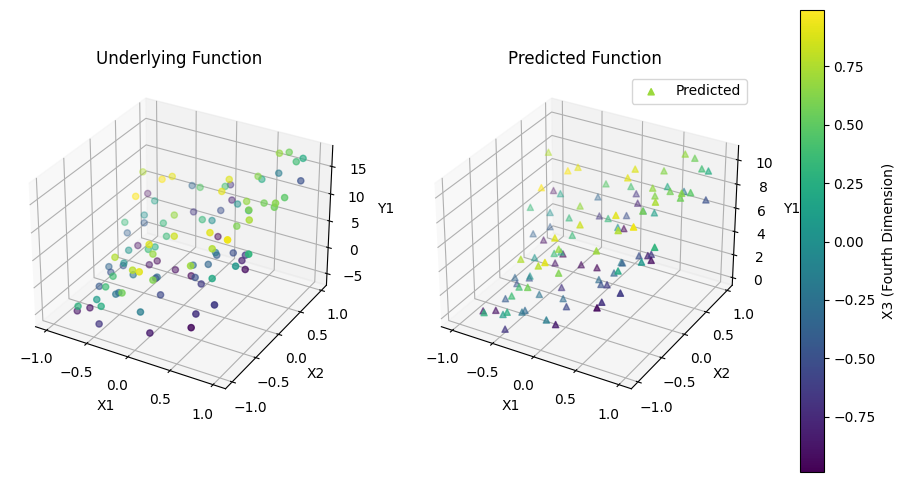

In [70]:
y_pred = predict(state, x_test)
print(jnp.mean((y_pred - y_test) ** 2))
plot_function_and_predictions_4d(x_test, y_test, y_pred)